# Imports

In [2]:
#!pip install pyLDAvis
#!pip install visdom
import pandas as pd
import nltk
import re
import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from sklearn.feature_extraction.text import CountVectorizer
tqdm.pandas()

# Data

In [312]:
df_kickstarter = pd.read_csv('../kickstarter.csv')

In [313]:
len(df_kickstarter.index)

574617

In [129]:
#from google.colab import drive
#drive.mount('/content/drive')
df_lda_kickstarter = pd.read_csv('../kickstarter_cleaned_BERTPPL_Readability.csv')

In [314]:
len(df_lda_kickstarter.index)

344669

# Functions

In [4]:
def preprocess_text(document: str, stemmer: nltk.stem.WordNetLemmatizer, en_stop: set) -> list:
    """Preprocesses a document to remove special characters/whitespace/etc

    Args:
        document (str):
        stemmer (nltk.stem.WordNetLemmatizer): Stemmer from NLTK
        en_stop (set): Set of stop words, usually from NLTK

    Returns:
        str: preprocessed document
    """

    # Remove all the special characters
    document = re.sub(r'\W', ' ', document)

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)

    # Converting to Lowercase
    document = document.lower()

    # Tokenization
    tokens = nltk.word_tokenize(document)

    # POS-Tagging
    tagged_tokens = nltk.pos_tag(tokens)

    # Filter Nouns and Lemmatization
    lemmatized_nouns = []
    for token, pos in tagged_tokens:
        if pos.startswith('N'):  # Check if the token is a noun
            lemma = stemmer.lemmatize(token)
            # FIlter stop words, words that contain only numbers and short words
            if lemma not in en_stop and not lemma.isdigit() and len(lemma) > 2:
                lemmatized_nouns.append(lemma)

    return lemmatized_nouns;

In [5]:
def preprocess_text_helper(t):
    stemmer = nltk.stem.WordNetLemmatizer()
    return preprocess_text(t, stemmer, stopwords.words('english'))

In [71]:
# Create function to calculate topic distribution
def get_topic_distribution(text, dictionary, model):
    bow = dictionary.doc2bow(text)
    topic_probs = model.get_document_topics(bow)
    return topic_probs

In [6]:
# Create a function to extract the top n descriptions corresponding to a topic
def get_top_descriptions(model, df, corpus, chosen_topic, n):

    print(model.show_topic(chosen_topic, topn=10))

    # Get the document-topic distribution
    document_topic_distribution = model.get_document_topics(corpus)

    # Ensure chosen_topic is within the valid range
    if 0 <= chosen_topic < model.num_topics:
        # Sort documents by their probability score for the chosen topic
        sorted_documents = sorted(
            enumerate(document_topic_distribution),
            key=lambda x: next((prob for topic, prob in x[1] if topic == chosen_topic), 0),
            reverse=True
        )
        top_n = 5  # Number of top documents to print
        for i, (doc_id, topic_probs) in enumerate(sorted_documents[:top_n]):
            document = corpus[doc_id]
            project_description = df.iloc[doc_id]['project_description']
            processed_description = df.iloc[doc_id]['processed_description']
            print(f"Document {i + 1} (Corpus ID {doc_id}):")
            print("Topic Probability:", next((prob for topic, prob in topic_probs if topic == chosen_topic), 0))
            words = [word for word, freq in document]
            print("Document Text:", words)
            print("Project Description:", project_description)
            print("processed Description:", processed_description)
            print("\n")
    else:
        print(f"Chosen topic index {chosen_topic} is out of range.")

In [44]:
def assign_topics(model, df, corpus):
    """
    Transform the DataFrame by adding columns for each topic as a binary variable
    and assigning ones to the top 3 topics with the highest probability for each row.
    """
    num_topics = model.num_topics
    topic_probabilities = model.get_document_topics(corpus)

    # Initialize columns for each topic as binary variables
    for i in range(num_topics):
        df[f"Topic_{i}"] = 0

    print(topic_probabilities)
    
    for i, topic_probs in enumerate(topic_probabilities):
        print(topic_probs)
        # Sort topic probabilities for the current document
        sorted_probs = sorted(topic_probs, key=lambda x: x[1], reverse=True)
        top_topics = sorted_probs[:3]  # Extract top 3 topics

        # Assign ones to corresponding columns for the top topics
        for topic, prob in top_topics:
            df.at[df.index[i], f"Topic_{topic}"] = 1
            print(prob)

    return df

In [82]:
def assign_topic_dist(model, df, corpus):
    
     topic_dists = []

     topic_probabilities = model.get_document_topics(corpus)
    
     for (doc_id, topic_probs) in enumerate(topic_probabilities):
         topic_dists.append(topic_probs)

     df['topic_dist'] = topic_dists

In [282]:
def calculate_relative_weighted_topic_prevelances_per_year(df, model):

    # Initialize a new DataFrame to store the results
    topic_df = pd.DataFrame(columns=['year'])

    # Get unique years
    unique_years = df['year'].unique()

    # Get number of topics
    num_topics = model.num_topics

    # Iterate over unique years and perform operations
    for year in unique_years:
        # Filter data for the current year
        year_data = df[df['year'] == year]

        # Sum up topic probabilities and calculate mean for each topic
        topic_prob_sums = {i: 0 for i in range(num_topics)}
        for dist in year_data['topic_dist']:
            for topic, prob in dist:
                topic_prob_sums[topic] += prob

        # stores the mean probability of each topic across all documents, weighted by the probability of that topic in each document
        topic_means_weighted = {topic: topic_prob_sums[topic] / len(year_data.index) for topic in topic_prob_sums}

        # Create a dictionary with year and topic mean probabilities
        topic_means_weighted['year'] = year

        # Append the calculated means for the current year to the result DataFrame
        topic_df = topic_df.append(topic_means_weighted, ignore_index=True)

    return topic_df

In [118]:
def calculate_difference_average_topic_prevelance(df, df_topic):

    # Initialize a new column to store the differences
    df['difference_average_topic_prevalence'] = 0.0

    # Iterate over rows using iterrows
    for index, row in df.iterrows():
        year = int(row['year'])
        if(year == 2009):
            continue
        else:
            topic_dist = row['topic_dist']
            topics_current_year = df_topic[df_topic['year'] == str(year)]
            topics_last_year = df_topic[df_topic['year'] == str(year - 1)]
            for topic, prob in topic_dist:
                # Calculate the difference in average topic prevalence for each topic in the distribution
                diff = prob * (topics_current_year[topic].values[0] - topics_last_year[topic].values[0])
                df.at[index, 'difference_average_topic_prevalence'] += diff

In [178]:
# base code
import numpy as np
import seaborn as sns
import statsmodels
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

style_talk = 'seaborn-talk'    #refer to plt.style.available

class LinearRegDiagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Authors:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.

        Matt Spinelli (m3spinelli@gmail.com, where 3 = r)
        (1) Fixed incorrect annotation of the top most extreme residuals in
            the Residuals vs Fitted and, especially, the Normal Q-Q plots.
        (2) Changed Residuals vs Leverage plot to match closer the y-axis
            range shown in the equivalent plot in the R package ggfortify.
        (3) Added horizontal line at y=0 in Residuals vs Leverage plot to
            match the plots in R package ggfortify and base R.
        (4) Added option for placing a vertical guideline on the Residuals
            vs Leverage plot using the rule of thumb of h = 2p/n to denote
            high leverage (high_leverage_threshold=True).
        (5) Added two more ways to compute the Cook's Distance (D) threshold:
            * 'baseR': D > 1 and D > 0.5 (default)
            * 'convention': D > 4/n
            * 'dof': D > 4 / (n - k - 1)
        (6) Fixed class name to conform to Pascal casing convention
        (7) Fixed Residuals vs Leverage legend to work with loc='best'
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)
        self.nresids = len(self.residual_norm)

    def __call__(self, plot_context='seaborn-paper', **kwargs):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(
                ax=ax[1,1],
                high_leverage_threshold = kwargs.get('high_leverage_threshold'),
                cooks_threshold = kwargs.get('cooks_threshold'))
            plt.show()

        return self.vif_table(), fig, ax,

    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.argsort(residual_abs), 0)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        fig = QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(QQ.theoretical_quantiles, abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(x, y),
                ha='right',
                color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')

        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None, high_leverage_threshold=False, cooks_threshold='baseR'):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        factors = []
        if cooks_threshold == 'baseR' or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == 'convention':
            factors = [4/self.nresids]
        elif cooks_threshold == 'dof':
            factors = [4/ (self.nresids - self.nparams)]
        else:
            raise ValueError("threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)")
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls='--', color='red')
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls='--', color='red')

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(high_leverage, label='High leverage', ls='-.', color='purple', lw=1)

        ax.axhline(0, ls='dotted', color='black', lw=1.25)
        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_ylim(min(self.residual_norm)-0.1, max(self.residual_norm)+0.1)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        plt.legend(loc='best')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        return (vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y


    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative == None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = quantiles[quant_index] if is_negative else np.flip(quantiles, 0)[quant_index]
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y


# LDA

In [55]:
# Remove the columns
df_lda_kickstarter.drop(df_lda_kickstarter.columns.difference(['project_description', 'project_category_id', 'project_parent_category_id', 'project_state', 'project_launched_at']), axis=1,inplace=True)

In [130]:
df_lda_kickstarter_technology_copy = df_lda_kickstarter.copy()

In [131]:
# Filter Dataframe by Technology category (number 16)
df_lda_kickstarter_technology_copy = df_lda_kickstarter_technology_copy[(df_lda_kickstarter_technology_copy['project_category_id'] == 16) | (df_lda_kickstarter_technology_copy['project_parent_category_id'] == 16)]

In [58]:
df_lda_kickstarter_technology['project_launched_at'] = df_lda_kickstarter_technology_copy['project_launched_at']

C:\Users\CoolerMaster\AppData\Local\Temp\ipykernel_57564\4130171910.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lda_kickstarter_technology['project_launched_at'] = df_lda_kickstarter_technology_copy['project_launched_at']


In [96]:
df_lda_kickstarter_technology.head(5)

,project_category_id,project_parent_category_id,project_state,project_description,processed_description,project_launched_at,year,topic_dist
6,51,16.0,canceled,Gnash is an open source framework in PHP/MySQL...,"[gnash, source, framework, php, mysql, applica...",2009-05-12 22:57:18,2009,"[(4, 0.02390648), (9, 0.011175559), (17, 0.047..."
14,51,16.0,canceled,I've begun prototyping a low-cost LED light fo...,"[cost, light, product, something, kit, end, us...",2009-05-02 20:24:08,2009,"[(0, 0.040690374), (17, 0.020877069), (24, 0.0..."
24,51,16.0,successful,Zombies. They're a problem that no one wants t...,"[zombie, problem, one, zombpocalypse, differen...",2009-05-19 22:52:59,2009,"[(0, 0.026023882), (1, 0.026666006), (17, 0.01..."
38,51,16.0,failed,"The internet is a vast minefield, harboring vo...","[internet, deposit, genius, month, system, nug...",2009-05-16 00:11:53,2009,"[(0, 0.013396805), (10, 0.018042367), (21, 0.0..."
41,51,16.0,failed,"This is Patrick Roanhouse, Host and producer o...","[roanhouse, host, producer, plan8, podcast, ba...",2009-05-18 06:14:17,2009,"[(0, 0.032849055), (2, 0.010286786), (7, 0.130..."


In [60]:
df_lda_kickstarter_technology_copy.head(5)

,project_category_id,project_parent_category_id,project_state,project_launched_at,project_description
6,51,16.0,canceled,2009-05-12 22:57:18,Gnash is an open source framework in PHP/MySQL...
14,51,16.0,canceled,2009-05-02 20:24:08,I've begun prototyping a low-cost LED light fo...
24,51,16.0,successful,2009-05-19 22:52:59,Zombies. They're a problem that no one wants t...
38,51,16.0,failed,2009-05-16 00:11:53,"The internet is a vast minefield, harboring vo..."
41,51,16.0,failed,2009-05-18 06:14:17,"This is Patrick Roanhouse, Host and producer o..."


### Technology Category

In [8]:
df_lda_kickstarter_technology = df_lda_kickstarter.copy()

In [9]:
# Filter Dataframe by Technology category (number 16)
df_lda_kickstarter_technology = df_lda_kickstarter_technology[(df_lda_kickstarter_technology['project_category_id'] == 16) | (df_lda_kickstarter_technology['project_parent_category_id'] == 16)]

In [10]:
# Preprocessing general steps
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
df_lda_kickstarter_technology['processed_description'] = df_lda_kickstarter_technology['project_description'].progress_apply(preprocess_text_helper)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CoolerMaster\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CoolerMaster\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\CoolerMaster\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


  0%|          | 0/25653 [00:00<?, ?it/s]

In [11]:
data_technology = df_lda_kickstarter_technology['processed_description'].tolist()
# Compute n-grams
from gensim.models import Phrases

# Add n-grams to docs (only ones that appear 20 times or more).
ngrams_technology = Phrases(data_technology, min_count=20)

for idx in range(len(data_technology)):
    for token in ngrams_technology[data_technology[idx]]:
        if '_' in token:
            # Token is a n-grams, add to document.
            data_technology[idx].append(token)

In [12]:
# create dictionary
dictionary_technology = corpora.Dictionary(data_technology)

In [13]:
# Filter out words that occur less than 5 documents, or more than 50% of the documents.
dictionary_technology.filter_extremes(no_below=5, no_above=0.5)

In [14]:
# Define your custom stoplist
custom_stoplist_technology = ["project", "kickstarter", "pledge", "backer", "campaign", "goal", "product", "kickstarter_campaign", "funding_goal", "reward", "stretch", "stretch_goal", "fund", "funding", "pledge_level",
                            "tier", "reward_tier", "pledge_amount",
                            "play", "replay", "browser", "html5", "play_replay", "html5_browser", 
                            "people", "world", "thing", "lot", "device", "system", "user", "way", "technology", "use", "design", "year", "month", "day", "hour", "www", "com", "one"
                            "information", "opportunity", "fund", "funding", "technology", "s olution", "developement", "tech", "experience", "level", "support", "stretch", "stretch_goal", "let", "detail",
                            "option", "please", "help", "life", "idea", "share", "everything", "thank", "quality", "version"]
# Add your custom stop words to the dictionary
stop_ids_technology = [dictionary_technology.token2id[word] for word in custom_stoplist_technology if word in dictionary_technology.token2id]
# Remove the stop words from the dictionary
dictionary_technology.filter_tokens(bad_ids=stop_ids_technology)

In [15]:
# create corpus
corpus_technology = [dictionary_technology.doc2bow(tokens) for tokens in data_technology]

In [16]:
from collections import Counter

# Count word occurrences
word_counts_technology = Counter()
for doc in corpus_technology:
    for word_id, count in doc:
        word = dictionary_technology[word_id]
        word_counts_technology[word] += count

# Get most frequent words
most_common_technology = word_counts_technology.most_common(100)
print(most_common_technology)

[('app', 35322), ('power', 19311), ('video', 17889), ('phone', 17790), ('feature', 15033), ('part', 15025), ('team', 14904), ('business', 14458), ('development', 14429), ('battery', 13692), ('software', 13581), ('home', 13580), ('data', 13508), ('application', 12942), ('prototype', 12919), ('community', 12682), ('work', 12404), ('service', 12134), ('cost', 12047), ('company', 11999), ('platform', 11886), ('production', 11741), ('information', 11277), ('board', 10995), ('student', 10781), ('tool', 10613), ('friend', 10443), ('game', 10051), ('order', 10042), ('water', 10029), ('market', 9947), ('money', 9893), ('hand', 9853), ('access', 9654), ('light', 9309), ('control', 9257), ('case', 9192), ('computer', 9152), ('color', 9131), ('process', 9073), ('need', 9073), ('problem', 8656), ('place', 8630), ('everyone', 8574), ('medium', 8550), ('music', 8547), ('family', 8519), ('sensor', 8286), ('child', 8258), ('event', 8189), ('material', 7918), ('website', 7917), ('camera', 7880), ('space

In [17]:
print('Number of unique tokens: %d' % len(dictionary_technology))
print('Number of documents: %d' % len(corpus_technology))

Number of unique tokens: 17583
Number of documents: 25653


In [18]:
from gensim.models.callbacks import CoherenceMetric, DiffMetric, PerplexityMetric, ConvergenceMetric

# define perplexity callback
pl = PerplexityMetric(corpus=corpus_technology, logger="visdom", title="Perplexity")

# define other remaining metrics available
ch_umass = CoherenceMetric(corpus=corpus_technology, coherence="u_mass", logger="visdom", title="Coherence (u_mass)")
ch_cv = CoherenceMetric(corpus=corpus_technology, texts=data_technology, coherence="c_v", logger="visdom", title="Coherence (c_v)")
diff_kl = DiffMetric(distance="kullback_leibler", logger="visdom", title="Diff (kullback_leibler)")
convergence_kl = ConvergenceMetric(distance="jaccard", logger="visdom", title="Convergence (jaccard)")

callbacks = [pl, ch_umass, ch_cv, diff_kl, convergence_kl]

In [19]:
lda_model_technology = gensim.models.LdaModel(corpus=corpus_technology, id2word=dictionary_technology, num_topics=100, passes=15, per_word_topics=True, chunksize=1500, iterations=150, alpha='auto') #callbacks=callbacks

In [20]:
lda_model_technology.save('../LDA/technology/100/LDA_technology_100_final')

In [21]:
vis = gensimvis.prepare(lda_model_technology, corpus_technology, dictionary_technology)
pyLDAvis.save_html(vis, '../LDA/technology/vis/100_final.html')

d:\anaconda3\envs\Bachelorthesis\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [ ]:
get_top_descriptions(lda_model_technology, df_lda_kickstarter_technology, corpus_technology, 21, 10)

### Games Category

In [16]:
df_lda_kickstarter_games = df_lda_kickstarter.copy()

In [17]:
# Filter Dataframe by Games category (number 12)
df_lda_kickstarter_games = df_lda_kickstarter_games[(df_lda_kickstarter_games['project_category_id'] == 12) | (df_lda_kickstarter_games['project_parent_category_id'] == 12)]

In [18]:
# Preprocessing
df_lda_kickstarter_games['project_description'] = df_lda_kickstarter_games['project_description'].progress_apply(preprocess_text_helper)

  0%|          | 0/35790 [00:00<?, ?it/s]

In [19]:
data_games = df_lda_kickstarter_games['project_description'].tolist()
# Compute bigrams/trigrams
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
ngrams_games = Phrases(data_games, min_count=20)
for idx in range(len(data_games)):
    for token in ngrams_games[data_games[idx]]:
        if '_' in token:
            # Token is a bigram/trigram, add to document.
            data_games[idx].append(token)

In [20]:
# create dictionary
dictionary_games = corpora.Dictionary(data_games)

In [21]:
# Filter out words that occur less than 5 documents, or more than 50% of the documents.
dictionary_games.filter_extremes(no_below=5, no_above=0.5)

In [22]:
# Define your custom stoplist
custom_stoplist_games = ["project", "kickstarter", "pledge", "backer", "campaign", "goal", "product", "kickstarter_campaign", "funding_goal", "reward", "stretch", "stretch_goal", "fund", "funding", "pledge_level",
                        "tier", "reward_tier", "pledge_amount",
                        "play", "replay", "browser", "html5", "play_replay", "html5_browser",
                        "year", "month", "day", "hour",
                        "people", "thing", "lot", "let", "something", "anyone", "card", "help", "one", "thing", "character", "video", "level", "design", "use",
                        "system", "feature", "play", "style", "title", "feedback", "support", "version", "please", "www", "com", "life", "way", "world", "idea", "share", "everything", "thank", "quality", "version"]                       
# Add your custom stop words to the dictionary
stop_ids_games = [dictionary_games.token2id[word] for word in custom_stoplist_games if word in dictionary_games.token2id]
# Remove the stop words from the dictionary
dictionary_games.filter_tokens(bad_ids=stop_ids_games)

In [23]:
# create corpus
corpus_games = [dictionary_games.doc2bow(tokens) for tokens in data_games]

In [31]:
from collections import Counter

# Count word occurrences
word_counts_games = Counter()
for doc in corpus_games:
    for word_id, count in doc:
        word = dictionary_games[word_id]
        word_counts_games[word] += count

# Get most frequent words
most_common_games = word_counts_games.most_common(100)
print(most_common_games)

[('deck', 51270), ('book', 30165), ('dice', 29503), ('art', 29073), ('board', 25934), ('rule', 24708), ('story', 24141), ('box', 23815), ('copy', 23200), ('shipping', 22741), ('team', 22395), ('adventure', 22082), ('friend', 21723), ('set', 21591), ('cost', 20616), ('order', 20413), ('point', 20404), ('edition', 19916), ('item', 19505), ('hand', 19351), ('color', 19134), ('experience', 18563), ('work', 17718), ('part', 17517), ('page', 17139), ('action', 16457), ('fun', 16303), ('number', 15853), ('monster', 15520), ('power', 15290), ('everyone', 15282), ('print', 15147), ('piece', 15054), ('battle', 14921), ('ability', 14715), ('artist', 14209), ('map', 14118), ('development', 14014), ('money', 13944), ('option', 13186), ('expansion', 13156), ('place', 13135), ('family', 12912), ('end', 12906), ('name', 12869), ('hero', 12617), ('space', 12525), ('city', 12448), ('turn', 12390), ('community', 12026), ('custom', 12001), ('pack', 11588), ('production', 11576), ('event', 11535), ('compan

In [32]:
print('Number of unique tokens: %d' % len(dictionary_games))
print('Number of documents: %d' % len(corpus_games))

Number of unique tokens: 25819
Number of documents: 35790


In [33]:
from gensim.models.callbacks import CoherenceMetric, DiffMetric, PerplexityMetric, ConvergenceMetric

# define perplexity callback
pl = PerplexityMetric(corpus=corpus_games, logger="visdom", title="Perplexity")

# define other remaining metrics available
ch_umass = CoherenceMetric(corpus=corpus_games, coherence="u_mass", logger="visdom", title="Coherence (u_mass)")
ch_cv = CoherenceMetric(corpus=corpus_games, texts=data_games, coherence="c_v", logger="visdom", title="Coherence (c_v)")
diff_kl = DiffMetric(distance="kullback_leibler", logger="visdom", title="Diff (kullback_leibler)")
convergence_kl = ConvergenceMetric(distance="jaccard", logger="visdom", title="Convergence (jaccard)")

callbacks = [pl, ch_umass, ch_cv, diff_kl, convergence_kl]

In [34]:
lda_model_games = gensim.models.LdaModel(corpus=corpus_games, id2word=dictionary_games, num_topics=70, passes=15, per_word_topics=True, chunksize=2000, iterations=150, alpha='auto')

In [35]:
lda_model_games.save('../LDA/games/70/LDA_games_70_final')

In [36]:
vis = gensimvis.prepare(lda_model_games, corpus_games, dictionary_games)
pyLDAvis.save_html(vis, '../LDA/games/vis/70_final.html')

d:\anaconda3\envs\Bachelorthesis\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


### Design Category

In [24]:
df_lda_kickstarter_design = df_lda_kickstarter.copy()

In [25]:
# Filter Dataframe by Design category (number 7)
df_lda_kickstarter_design = df_lda_kickstarter_design[(df_lda_kickstarter_design['project_category_id'] == 7) | (df_lda_kickstarter_design['project_parent_category_id'] == 7)]

In [26]:
# Preprocessing general steps
nltk.download('stopwords')
nltk.download('wordnet')
df_lda_kickstarter_design['project_description'] = df_lda_kickstarter_design['project_description'].progress_apply(preprocess_text_helper)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CoolerMaster\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CoolerMaster\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  0%|          | 0/27356 [00:00<?, ?it/s]

In [27]:
data_design = df_lda_kickstarter_design['project_description'].tolist()
# Compute n-grams
from gensim.models import Phrases

# Add n-grams to docs (only ones that appear 20 times or more).
ngrams_design = Phrases(data_design, min_count=20)
for idx in range(len(data_design)):
    for token in ngrams_design[data_design[idx]]:
        if '_' in token:
            # Token is a n-grams, add to document.
            data_design[idx].append(token)

In [28]:
# create dictionary
dictionary_design = corpora.Dictionary(data_design)

In [29]:
# Filter out words that occur less than 5 documents, or more than 50% of the documents.
dictionary_design.filter_extremes(no_below=5, no_above=0.5)

In [30]:
# Define your custom stoplist
custom_stoplist_design = ["project", "kickstarter", "pledge", "backer", "campaign", "goal", "product", "kickstarter_campaign", "funding_goal", "reward", "stretch", "stretch_goal", "fund", "funding", "pledge_level",
                        "tier", "reward_tier", "pledge_amount",
                        "play", "replay", "browser", "html5", "play_replay", "html5_browser",
                        "year", "month", "day", "hour",
                        "people", "life", "way", "world", "idea", "share", "everything", "thank", "quality", "version", "thing", "lot", "let", "something", "anyone", "card", "help", "one", 
                        "thing", "character", "video", "level", "design", "use", "system", "feature", "play", "style", "title", "feedback", "support", "version", "please", "www", "com"]
# Add your custom stop words to the dictionary
stop_ids_design = [dictionary_design.token2id[word] for word in custom_stoplist_design if word in dictionary_design.token2id]
# Remove the stop words from the dictionary
dictionary_design.filter_tokens(bad_ids=stop_ids_design)

In [31]:
# create corpus
corpus_design = [dictionary_design.doc2bow(tokens) for tokens in data_design]

In [45]:
from collections import Counter

# Count word occurrences
word_counts_design = Counter()
for doc in corpus_design:
    for word_id, count in doc:
        word = dictionary_design[word_id]
        word_counts_design[word] += count

# Get most frequent words
most_common_design = word_counts_design.most_common(100)
print(most_common_design)

[('production', 23017), ('color', 22842), ('material', 21412), ('hand', 20498), ('prototype', 18012), ('bag', 17607), ('case', 16266), ('order', 15837), ('size', 15638), ('part', 15272), ('water', 15033), ('work', 13376), ('home', 12581), ('process', 12509), ('tool', 12506), ('cost', 11615), ('pocket', 11440), ('company', 11289), ('phone', 11129), ('friend', 10742), ('piece', 10544), ('place', 10535), ('option', 10520), ('experience', 10493), ('space', 10281), ('steel', 9811), ('market', 9763), ('business', 9712), ('wallet', 9606), ('team', 9534), ('device', 9348), ('family', 9285), ('line', 9028), ('shipping', 8790), ('side', 8739), ('box', 8713), ('watch', 8697), ('bottle', 8558), ('child', 8368), ('model', 8134), ('end', 8120), ('everyone', 8039), ('item', 8037), ('power', 7976), ('community', 7944), ('problem', 7926), ('need', 7921), ('body', 7918), ('art', 7628), ('manufacturing', 7575), ('price', 7525), ('custom', 7490), ('money', 7420), ('strap', 7216), ('plastic', 7177), ('boar

In [46]:
print('Number of unique tokens: %d' % len(dictionary_design))
print('Number of documents: %d' % len(corpus_design))

Number of unique tokens: 19990
Number of documents: 27356


In [47]:
from gensim.models.callbacks import CoherenceMetric, DiffMetric, PerplexityMetric, ConvergenceMetric

# define perplexity callback
pl = PerplexityMetric(corpus=corpus_design, logger="visdom", title="Perplexity")

# define other remaining metrics available
ch_umass = CoherenceMetric(corpus=corpus_design, coherence="u_mass", logger="visdom", title="Coherence (u_mass)")
ch_cv = CoherenceMetric(corpus=corpus_design, texts=data_design, coherence="c_v", logger="visdom", title="Coherence (c_v)")
diff_kl = DiffMetric(distance="kullback_leibler", logger="visdom", title="Diff (kullback_leibler)")
convergence_kl = ConvergenceMetric(distance="jaccard", logger="visdom", title="Convergence (jaccard)")

callbacks = [pl, ch_umass, ch_cv, diff_kl, convergence_kl]

In [48]:
lda_model_design = gensim.models.LdaModel(corpus=corpus_design, id2word=dictionary_design, num_topics=100, passes=15, per_word_topics=True, chunksize=1500, iterations=150, alpha='auto')

In [49]:
lda_model_design.save('../LDA/design/100/LDA_design_100_final')

In [50]:
vis = gensimvis.prepare(lda_model_design, corpus_design, dictionary_design)
pyLDAvis.save_html(vis, '../LDA/design/vis/100_final.html')

d:\anaconda3\envs\Bachelorthesis\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


# Loading Models

In [34]:
lda_model_technology = gensim.models.LdaModel.load('../LDA/technology/100/LDA_technology_100_final')

In [35]:
lda_model_games = gensim.models.LdaModel.load('../LDA/games/70/LDA_games_70_final')

In [36]:
lda_model_design = gensim.models.LdaModel.load('../LDA/design/100/LDA_design_100_final')

# Relative topic distribution over time

## Technology category

In [49]:
from datetime import datetime

In [61]:
df_lda_kickstarter_technology["year"] = pd.to_datetime(df_lda_kickstarter_technology['project_launched_at']).dt.strftime('%Y')

C:\Users\CoolerMaster\AppData\Local\Temp\ipykernel_57564\3331068483.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lda_kickstarter_technology["year"] = pd.to_datetime(df_lda_kickstarter_technology['project_launched_at']).dt.strftime('%Y')


In [84]:
assign_topic_dist(lda_model_technology, df_lda_kickstarter_technology, corpus_technology)

In [85]:
df_lda_kickstarter_technology.head(5)

,project_category_id,project_parent_category_id,project_state,project_description,processed_description,project_launched_at,year,topic_dist
6,51,16.0,canceled,Gnash is an open source framework in PHP/MySQL...,"[gnash, source, framework, php, mysql, applica...",2009-05-12 22:57:18,2009,"[(4, 0.02390648), (9, 0.011175559), (17, 0.047..."
14,51,16.0,canceled,I've begun prototyping a low-cost LED light fo...,"[cost, light, product, something, kit, end, us...",2009-05-02 20:24:08,2009,"[(0, 0.040690374), (17, 0.020877069), (24, 0.0..."
24,51,16.0,successful,Zombies. They're a problem that no one wants t...,"[zombie, problem, one, zombpocalypse, differen...",2009-05-19 22:52:59,2009,"[(0, 0.026023882), (1, 0.026666006), (17, 0.01..."
38,51,16.0,failed,"The internet is a vast minefield, harboring vo...","[internet, deposit, genius, month, system, nug...",2009-05-16 00:11:53,2009,"[(0, 0.013396805), (10, 0.018042367), (21, 0.0..."
41,51,16.0,failed,"This is Patrick Roanhouse, Host and producer o...","[roanhouse, host, producer, plan8, podcast, ba...",2009-05-18 06:14:17,2009,"[(0, 0.032849055), (2, 0.010286786), (7, 0.130..."


In [283]:
topic_df_technology = calculate_relative_weighted_topic_prevelances_per_year(df_lda_kickstarter_technology, lda_model_technology)

C:\Users\CoolerMaster\AppData\Local\Temp\ipykernel_57564\2814669064.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_df = topic_df.append(topic_means_weighted, ignore_index=True)
C:\Users\CoolerMaster\AppData\Local\Temp\ipykernel_57564\2814669064.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_df = topic_df.append(topic_means_weighted, ignore_index=True)
C:\Users\CoolerMaster\AppData\Local\Temp\ipykernel_57564\2814669064.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_df = topic_df.append(topic_means_weighted, ignore_index=True)
C:\Users\CoolerMaster\AppData\Local\Temp\ipykernel_57564\2814669064.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

In [286]:
topic_df_technology.head(20)

,year,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,2009,0.053170,0.002298,0.001570,0.009938,0.002928,0.000856,0.003310,0.026125,0.001848,...,0.004762,0.004861,0.010933,0.006727,0.000745,0.000000,0.001481,0.005735,0.011955,0.048388
1,2010,0.037356,0.003547,0.004176,0.008450,0.008386,0.001415,0.003076,0.017251,0.005125,...,0.006720,0.002994,0.007472,0.003444,0.001086,0.003093,0.001238,0.006579,0.013114,0.057782
2,2011,0.027289,0.003089,0.005094,0.007508,0.006947,0.002564,0.002830,0.013031,0.004562,...,0.007098,0.003297,0.005186,0.003385,0.003665,0.008491,0.003614,0.007836,0.007912,0.037018
3,2013,0.020713,0.003634,0.008666,0.007718,0.009387,0.001464,0.003718,0.008225,0.005143,...,0.004726,0.002083,0.005466,0.002479,0.005305,0.010457,0.004685,0.007672,0.008350,0.024123
4,2016,0.044392,0.003500,0.005764,0.011103,0.008122,0.001391,0.004888,0.006621,0.004553,...,0.002735,0.002463,0.004967,0.003392,0.004144,0.010647,0.004411,0.006567,0.006355,0.035152
5,2012,0.020718,0.004059,0.007112,0.006795,0.008871,0.001565,0.002632,0.011304,0.006514,...,0.005907,0.001679,0.005809,0.003083,0.004413,0.008918,0.002237,0.008865,0.007195,0.030054
6,2014,0.040568,0.003894,0.007047,0.010701,0.008450,0.001764,0.003905,0.008122,0.005163,...,0.003307,0.002084,0.005587,0.003515,0.003724,0.007902,0.004069,0.007172,0.008094,0.033511
7,2015,0.044722,0.004160,0.006067,0.010922,0.007876,0.001856,0.004104,0.007425,0.005254,...,0.003002,0.002392,0.005445,0.003217,0.003823,0.007583,0.004257,0.006807,0.007552,0.036950
8,2017,0.043149,0.003793,0.004665,0.012778,0.008125,0.001764,0.004486,0.007421,0.004511,...,0.003201,0.002060,0.005481,0.003566,0.004122,0.009971,0.004493,0.007129,0.005801,0.034344
9,2018,0.042609,0.003370,0.005129,0.013195,0.008103,0.001513,0.004714,0.006587,0.003962,...,0.003216,0.002676,0.004500,0.003309,0.004079,0.011755,0.004550,0.008048,0.006504,0.035651


In [285]:
print(topic_df_technology.sum(axis = 1))

0     0.843087
1     0.855553
2     0.858903
3     0.866598
4     0.851622
5     0.866899
6     0.852988
7     0.847678
8     0.849121
9     0.851536
10    0.854617
11    0.855822
12    0.860097
13    0.857131
14    0.863949
dtype: float64


C:\Users\CoolerMaster\AppData\Local\Temp\ipykernel_57564\3066568977.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(topic_df_technology.sum(axis = 1))


In [287]:
calculate_difference_average_topic_prevelance(df_lda_kickstarter_technology, topic_df_technology)

In [124]:
df_lda_kickstarter_technology.head(100)

,project_category_id,project_parent_category_id,project_state,project_description,processed_description,project_launched_at,year,topic_dist,difference_average_topic_prevalence
6,51,16.0,canceled,Gnash is an open source framework in PHP/MySQL...,"[gnash, source, framework, php, mysql, applica...",2009-05-12 22:57:18,2009,"[(4, 0.02390648), (9, 0.011175559), (17, 0.047...",0.000000
14,51,16.0,canceled,I've begun prototyping a low-cost LED light fo...,"[cost, light, product, something, kit, end, us...",2009-05-02 20:24:08,2009,"[(0, 0.040690374), (17, 0.020877069), (24, 0.0...",0.000000
24,51,16.0,successful,Zombies. They're a problem that no one wants t...,"[zombie, problem, one, zombpocalypse, differen...",2009-05-19 22:52:59,2009,"[(0, 0.026023882), (1, 0.026666006), (17, 0.01...",0.000000
38,51,16.0,failed,"The internet is a vast minefield, harboring vo...","[internet, deposit, genius, month, system, nug...",2009-05-16 00:11:53,2009,"[(0, 0.013396805), (10, 0.018042367), (21, 0.0...",0.000000
41,51,16.0,failed,"This is Patrick Roanhouse, Host and producer o...","[roanhouse, host, producer, plan8, podcast, ba...",2009-05-18 06:14:17,2009,"[(0, 0.032849055), (2, 0.010286786), (7, 0.130...",0.000000
...,...,...,...,...,...,...,...,...,...
3031,52,16.0,failed,I am creating a four legged (Quadruped) robot ...,"[degree, freedom, leg, terrain, proximity, obj...",2010-06-27 04:23:11,2010,"[(2, 0.068835296), (11, 0.010866949), (15, 0.0...",-0.288457
3038,51,16.0,failed,What is the FLLO? www.thefllo.com\r\n\r\n As a...,"[www, thefllo, com, college, student, france, ...",2010-07-18 19:17:04,2010,"[(0, 0.05640574), (5, 0.04635258), (17, 0.0123...",-0.697488
3063,51,16.0,failed,_arthrow is an exchange space where artists sw...,"[_arthrow, exchange, space, artist, material, ...",2010-07-01 07:58:40,2010,"[(0, 0.03528575), (1, 0.020752553), (3, 0.0237...",-0.737317
3065,51,16.0,failed,The iPad has changed the way we interact with ...,"[ipad, way, internet, internet, hole, experien...",2010-07-04 22:48:45,2010,"[(0, 0.028218562), (13, 0.020848963), (17, 0.0...",-0.300366


In [288]:
df_lda_kickstarter_technology['difference_average_topic_prevalence'] = df_lda_kickstarter_technology['difference_average_topic_prevalence'] * 100

In [289]:
# Count of positive values
positive_count = (df_lda_kickstarter_technology['difference_average_topic_prevalence'] > 0).sum()

# Count of negative values
negative_count = (df_lda_kickstarter_technology['difference_average_topic_prevalence'] < 0).sum()

print(f'Number of positive values: {positive_count}')
print(f'Number of negative values: {negative_count}')

Number of positive values: 13223
Number of negative values: 12388


In [290]:
print(df_lda_kickstarter_technology['difference_average_topic_prevalence'].mean())

0.012413489185144386


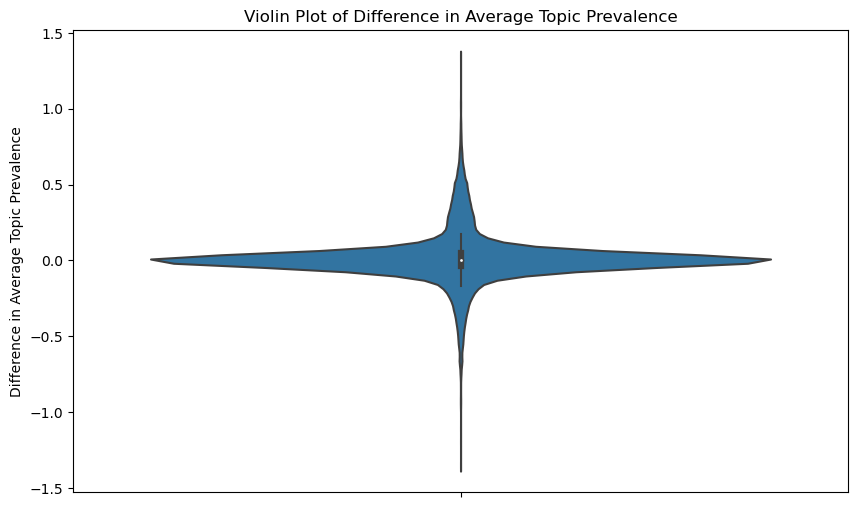

In [186]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a violin plot for the 'difference_average_topic_prevalence' variable
plt.figure(figsize=(10, 6))
sns.violinplot(y='difference_average_topic_prevalence', data=df_lda_kickstarter_technology)
plt.title('Violin Plot of Difference in Average Topic Prevalence')
plt.ylabel('Difference in Average Topic Prevalence')
plt.show()


## Games category

In [206]:
df_lda_kickstarter_games_copy = df_lda_kickstarter.copy()
# Filter Dataframe by Games category (number 12)
df_lda_kickstarter_games_copy = df_lda_kickstarter_games_copy[(df_lda_kickstarter_games_copy['project_category_id'] == 12) | (df_lda_kickstarter_games_copy['project_parent_category_id'] == 12)]
df_lda_kickstarter_games['project_launched_at'] = df_lda_kickstarter_games_copy['project_launched_at']

In [207]:
df_lda_kickstarter_games["year"] = pd.to_datetime(df_lda_kickstarter_games['project_launched_at']).dt.strftime('%Y')

In [208]:
assign_topic_dist(lda_model_games, df_lda_kickstarter_games, corpus_games)

In [291]:
topic_df_games = calculate_relative_weighted_topic_prevelances_per_year(df_lda_kickstarter_games, lda_model_games)

C:\Users\CoolerMaster\AppData\Local\Temp\ipykernel_57564\2814669064.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_df = topic_df.append(topic_means_weighted, ignore_index=True)
C:\Users\CoolerMaster\AppData\Local\Temp\ipykernel_57564\2814669064.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_df = topic_df.append(topic_means_weighted, ignore_index=True)
C:\Users\CoolerMaster\AppData\Local\Temp\ipykernel_57564\2814669064.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_df = topic_df.append(topic_means_weighted, ignore_index=True)
C:\Users\CoolerMaster\AppData\Local\Temp\ipykernel_57564\2814669064.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

In [292]:
calculate_difference_average_topic_prevelance(df_lda_kickstarter_games, topic_df_games)

In [293]:
df_lda_kickstarter_games['difference_average_topic_prevalence'] = df_lda_kickstarter_games['difference_average_topic_prevalence'] * 100

In [294]:
# Count of positive values
positive_count = (df_lda_kickstarter_games['difference_average_topic_prevalence'] > 0).sum()

# Count of negative values
negative_count = (df_lda_kickstarter_games['difference_average_topic_prevalence'] < 0).sum()

print(f'Number of positive values: {positive_count}')
print(f'Number of negative values: {negative_count}')

Number of positive values: 13687
Number of negative values: 22077


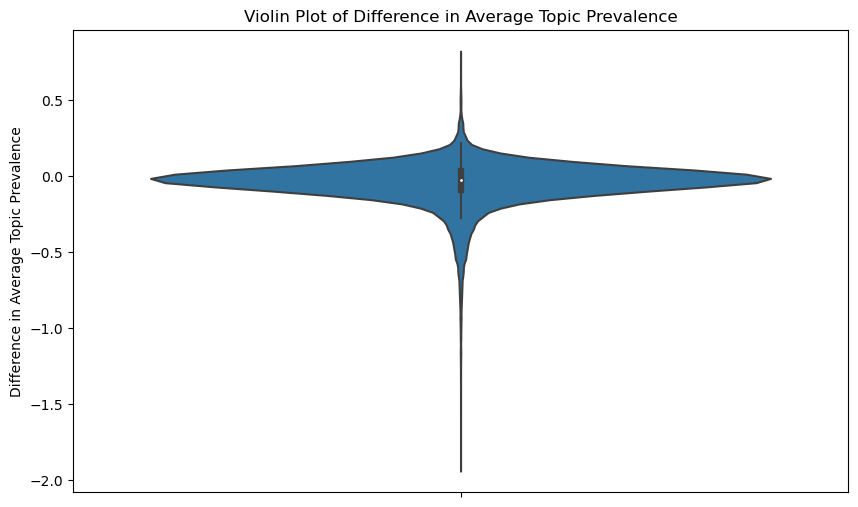

In [295]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a violin plot for the 'difference_average_topic_prevalence' variable
plt.figure(figsize=(10, 6))
sns.violinplot(y='difference_average_topic_prevalence', data=df_lda_kickstarter_games)
plt.title('Violin Plot of Difference in Average Topic Prevalence')
plt.ylabel('Difference in Average Topic Prevalence')
plt.show()

## Design category

In [216]:
df_lda_kickstarter_design_copy = df_lda_kickstarter.copy()
# Filter Dataframe by Design category (number 7)
df_lda_kickstarter_design_copy = df_lda_kickstarter_design_copy[(df_lda_kickstarter_design_copy['project_category_id'] == 7) | (df_lda_kickstarter_design_copy['project_parent_category_id'] == 7)]
df_lda_kickstarter_design['project_launched_at'] = df_lda_kickstarter_design_copy['project_launched_at']

In [217]:
df_lda_kickstarter_design["year"] = pd.to_datetime(df_lda_kickstarter_design['project_launched_at']).dt.strftime('%Y')

In [218]:
assign_topic_dist(lda_model_design, df_lda_kickstarter_design, corpus_design)

In [296]:
topic_df_design = calculate_relative_weighted_topic_prevelances_per_year(df_lda_kickstarter_design, lda_model_design)

C:\Users\CoolerMaster\AppData\Local\Temp\ipykernel_57564\2814669064.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_df = topic_df.append(topic_means_weighted, ignore_index=True)
C:\Users\CoolerMaster\AppData\Local\Temp\ipykernel_57564\2814669064.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_df = topic_df.append(topic_means_weighted, ignore_index=True)
C:\Users\CoolerMaster\AppData\Local\Temp\ipykernel_57564\2814669064.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_df = topic_df.append(topic_means_weighted, ignore_index=True)
C:\Users\CoolerMaster\AppData\Local\Temp\ipykernel_57564\2814669064.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

In [297]:
calculate_difference_average_topic_prevelance(df_lda_kickstarter_design, topic_df_design)

In [298]:
df_lda_kickstarter_design['difference_average_topic_prevalence'] = df_lda_kickstarter_design['difference_average_topic_prevalence'] * 100

In [299]:
# Count of positive values
positive_count = (df_lda_kickstarter_design['difference_average_topic_prevalence'] > 0).sum()

# Count of negative values
negative_count = (df_lda_kickstarter_design['difference_average_topic_prevalence'] < 0).sum()

print(f'Number of positive values: {positive_count}')
print(f'Number of negative values: {negative_count}')

Number of positive values: 10863
Number of negative values: 16475


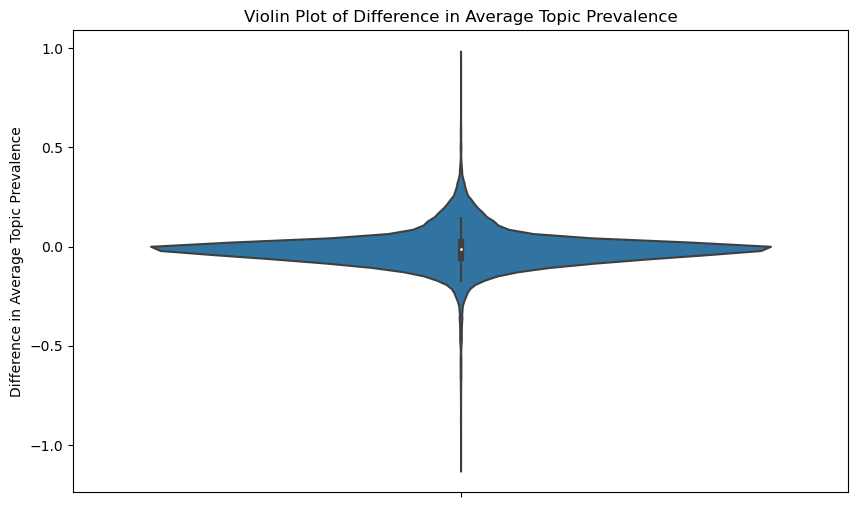

In [223]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a violin plot for the 'difference_average_topic_prevalence' variable
plt.figure(figsize=(10, 6))
sns.violinplot(y='difference_average_topic_prevalence', data=df_lda_kickstarter_design)
plt.title('Violin Plot of Difference in Average Topic Prevalence')
plt.ylabel('Difference in Average Topic Prevalence')
plt.show()

# OLS Modelling

## Technology category

In [133]:
import statsmodels.api as sm
import numpy as np

In [349]:
# Setting up Model Variables by transforming Data Columns
df_lda_kickstarter_technology_copy['project_launched_at'] = pd.to_datetime(df_lda_kickstarter_technology_copy['project_launched_at'])
df_lda_kickstarter_technology_copy['project_deadline'] = pd.to_datetime(df_lda_kickstarter_technology_copy['project_deadline'])
df_lda_kickstarter_technology_copy['month'] = pd.to_datetime(df_lda_kickstarter_technology_copy['project_launched_at']).dt.month
df_lda_kickstarter_technology_copy['timestamp_launched'] = df_lda_kickstarter_technology_copy['project_launched_at'].apply(lambda x: (datetime.timestamp(x) / 86400))
df_lda_kickstarter_technology_copy['timestamp_deadline'] = df_lda_kickstarter_technology_copy['project_deadline'].apply(lambda x: (datetime.timestamp(x) / 86400))

## Response Variable
CF_success = df_lda_kickstarter_technology_copy['project_pledged'].apply(lambda x: np.log(x) if x != 0 else 0)
success_binary = df_lda_kickstarter_technology_copy['project_state'].apply(lambda x: 1 if x == "successful" else 0)

## Explanatory Variables
difference_average_topic_prevalence = df_lda_kickstarter_technology['difference_average_topic_prevalence']

##Control Variables
loved_project = df_lda_kickstarter_technology_copy['project_staff_pick']
video = df_lda_kickstarter_technology_copy['project_video_url'].apply(lambda x: 0 if pd.isna(x) else 1)
funding_duration = df_lda_kickstarter_technology_copy['timestamp_deadline'] - df_lda_kickstarter_technology_copy['timestamp_launched']
number_of_words = df_lda_kickstarter_technology_copy['num_words'].apply(lambda x: np.log(x))
log_funding_goal = df_lda_kickstarter_technology_copy['project_goal'].apply(lambda x: np.log(x))
updates = df_lda_kickstarter_technology_copy['updates_until_deadline']
rewards = df_lda_kickstarter_technology_copy['project_rewards']
number_projects = df_lda_kickstarter_technology_copy['project_creator_project_number'].apply(lambda x: 0 if pd.isna(x) else x)

##Dummies
month_dummies = pd.get_dummies(df_lda_kickstarter_technology_copy['month'], prefix='month', drop_first=True)

In [351]:
# Create a new DataFrame to store the variables
df_model_technology = pd.DataFrame({
    'Difference in average topic prevalence': difference_average_topic_prevalence,
    'Difference in average topic prevalence^2': difference_average_topic_prevalence * difference_average_topic_prevalence,
    'Loved Project': loved_project,
    'Video': video,
    'Funding Duration': funding_duration,
    'Log(Number of Words)': number_of_words,
    'Log(Funding Goal)': log_funding_goal,
    'Updates': updates,
    'Rewards': rewards,
    'Number of projects': number_projects
})
# Concatenate the dummy variables
df_model_technology = pd.concat([df_model_technology, month_dummies], axis=1)

X_technology = df_model_technology

# Add a constant (intercept) to the feature matrix
X_technology_with_intercept = sm.add_constant(X_technology)

# Fit for model without time
model_technology = sm.Logit(success_binary, X_technology_with_intercept, 'raise').fit(cov_type='HC0')

# Print the summary of the regression results
print(model_technology.summary())

Optimization terminated successfully.
         Current function value: 0.307850
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          project_state   No. Observations:                25653
Model:                          Logit   Df Residuals:                    25631
Method:                           MLE   Df Model:                           21
Date:                Thu, 28 Sep 2023   Pseudo R-squ.:                  0.4305
Time:                        21:22:00   Log-Likelihood:                -7897.3
converged:                       True   LL-Null:                       -13866.
Covariance Type:                  HC0   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -0.2

In [309]:
X_technology_with_intercept.to_csv("./RegressionData_LDA_Technology.csv")

<Axes: >

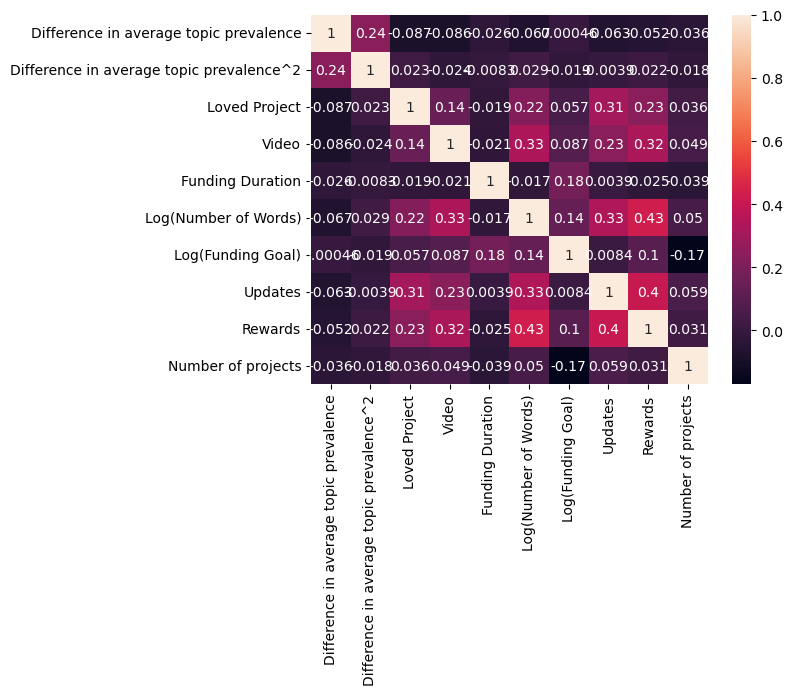

In [225]:
sns.heatmap(df_model_technology.corr(), annot = True)

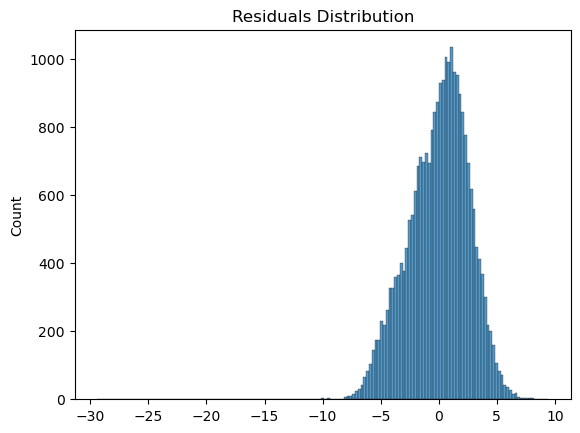

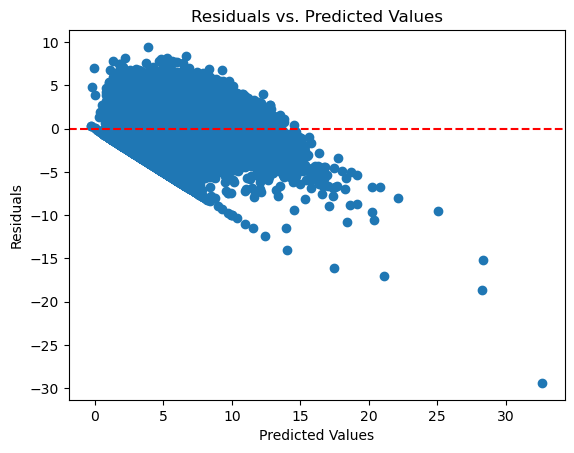

                                    Features         VIF
0                                      const  108.566416
1     Difference in average topic prevalence    1.077310
2   Difference in average topic prevalence^2    1.064441
3                              Loved Project    1.143220
4                                      Video    1.191930
5                           Funding Duration    1.039635
6                       Log(Number of Words)    1.363409
7                          Log(Funding Goal)    1.101082
8                                    Updates    1.319062
9                                    Rewards    1.415624
10                        Number of projects    1.040177


In [242]:
# Assuming 'model_squared_time' is your fitted model

# 1. Linearity
# Visualize scatter plots of predictors vs. response

# 2. Normality of Residuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(model_technology.resid)
plt.title('Residuals Distribution')
plt.show()

# 3. Homoscedasticity
plt.scatter(model_technology.predict(), model_technology.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

# 4. Independence of Residuals
# Use Durbin-Watson test or plot ACF of residuals

# 5. No Endogeneity
# Theoretical validation based on domain knowledge

# 6. Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["Features"] = X_technology_with_intercept.columns
vif["VIF"] = [variance_inflation_factor(X_technology_with_intercept.values, i) for i in range(X_technology_with_intercept.shape[1])]
print(vif)

# 7. No Perfect Multicollinearity
# Manual inspection of relationships between predictors

# Additional notes:

In [307]:
cls = LinearRegDiagnostic(model_technology)

d:\anaconda3\envs\Bachelorthesis\lib\contextlib.py:113: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  return next(self.gen)


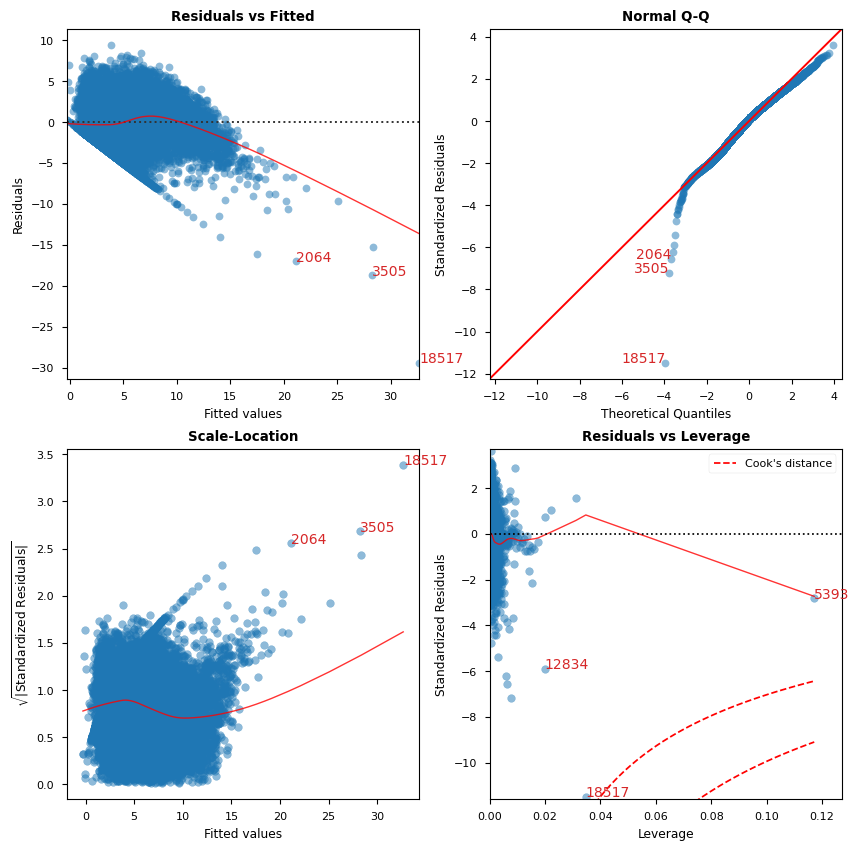

                                    Features  VIF Factor
5                               Funding Days        1.04
10                  Number of prior projects        1.04
2   Difference in average topic prevalence^2        1.06
1     Difference in average topic prevalence        1.08
7                          Log(Funding Goal)        1.10
3                              Loved Project        1.14
4                                      Video        1.19
8                                    Updates        1.32
6                       Log(Number of Words)        1.36
9                                    Rewards        1.42
0                                      const      108.57


In [308]:
vif, fig, ax = cls()
print(vif)

## Games category

In [321]:
# Setting up Model Variables by transforming Data Columns
df_lda_kickstarter_games_copy['project_launched_at'] = pd.to_datetime(df_lda_kickstarter_games_copy['project_launched_at'])
df_lda_kickstarter_games_copy['project_deadline'] = pd.to_datetime(df_lda_kickstarter_games_copy['project_deadline'])
df_lda_kickstarter_games_copy['month'] = pd.to_datetime(df_lda_kickstarter_games_copy['project_launched_at']).dt.month
df_lda_kickstarter_games_copy['timestamp_launched'] = df_lda_kickstarter_games_copy['project_launched_at'].apply(lambda x: (datetime.timestamp(x) / 86400))
df_lda_kickstarter_games_copy['timestamp_deadline'] = df_lda_kickstarter_games_copy['project_deadline'].apply(lambda x: (datetime.timestamp(x) / 86400))

## Response Variable
CF_success = df_lda_kickstarter_games_copy['project_pledged'].apply(lambda x: np.log(x) if x != 0 else 0)

## Explanatory Variables
difference_average_topic_prevalence = df_lda_kickstarter_games['difference_average_topic_prevalence']

##Control Variables
loved_project = df_lda_kickstarter_games_copy['project_staff_pick']
video = df_lda_kickstarter_games_copy['project_video_url'].apply(lambda x: 0 if pd.isna(x) else 1)
funding_duration = df_lda_kickstarter_games_copy['timestamp_deadline'] - df_lda_kickstarter_games_copy['timestamp_launched']
number_of_words = df_lda_kickstarter_games_copy['num_words'].apply(lambda x: np.log(x))
log_funding_goal = df_lda_kickstarter_games_copy['project_goal'].apply(lambda x: np.log(x))
updates = df_lda_kickstarter_games_copy['updates_until_deadline']
rewards = df_lda_kickstarter_games_copy['project_rewards']
number_projects = df_lda_kickstarter_games_copy['project_creator_project_number'].apply(lambda x: 0 if pd.isna(x) else x)

##Dummies
month_dummies = pd.get_dummies(df_lda_kickstarter_games_copy['month'], prefix='month', drop_first=True)

In [323]:
# Create a new DataFrame to store the variables
df_model_games = pd.DataFrame({
    'Difference in average topic prevalence': difference_average_topic_prevalence,
    'Difference in average topic prevalence^2': difference_average_topic_prevalence * difference_average_topic_prevalence,
    'Loved Project': loved_project,
    'Video': video,
    'Funding Duration': funding_duration,
    'Log(Number of Words)': number_of_words,
    'Log(Funding Goal)': log_funding_goal,
    'Updates': updates,
    'Rewards': rewards,
    'Number of projects': number_projects
})
# Concatenate the dummy variables
df_model_games = pd.concat([df_model_games, month_dummies], axis=1)

X_games = df_model_games
# Add a constant (intercept) to the feature matrix
X_games_with_intercept = sm.add_constant(X_games)

# Fit for model without time
model_games2 = sm.OLS(CF_success, X_games_with_intercept, 'raise').fit(cov_type='HC0')

# Print the summary of the regression results
#print(model_games.summary())

In [310]:
X_games_with_intercept.to_csv("./RegressionData_LDA_Games.csv")

## Design category

In [324]:
# Setting up Model Variables by transforming Data Columns
df_lda_kickstarter_design_copy['project_launched_at'] = pd.to_datetime(df_lda_kickstarter_design_copy['project_launched_at'])
df_lda_kickstarter_design_copy['project_deadline'] = pd.to_datetime(df_lda_kickstarter_design_copy['project_deadline'])
df_lda_kickstarter_design_copy['month'] = pd.to_datetime(df_lda_kickstarter_design_copy['project_launched_at']).dt.month
df_lda_kickstarter_design_copy['timestamp_launched'] = df_lda_kickstarter_design_copy['project_launched_at'].apply(lambda x: (datetime.timestamp(x) / 86400))
df_lda_kickstarter_design_copy['timestamp_deadline'] = df_lda_kickstarter_design_copy['project_deadline'].apply(lambda x: (datetime.timestamp(x) / 86400))

## Response Variable
CF_success = df_lda_kickstarter_design_copy['project_pledged'].apply(lambda x: np.log(x) if x != 0 else 0)
CF_success = CF_success.apply(lambda x: 0 if pd.isna(x) else x)

## Explanatory Variables
difference_average_topic_prevalence = df_lda_kickstarter_design['difference_average_topic_prevalence']

##Control Variables
loved_project = df_lda_kickstarter_design_copy['project_staff_pick']
video = df_lda_kickstarter_design_copy['project_video_url'].apply(lambda x: 0 if pd.isna(x) else 1)
funding_duration = df_lda_kickstarter_design_copy['timestamp_deadline'] - df_lda_kickstarter_design_copy['timestamp_launched']
number_of_words = df_lda_kickstarter_design_copy['num_words'].apply(lambda x: np.log(x))
log_funding_goal = df_lda_kickstarter_design_copy['project_goal'].apply(lambda x: np.log(x))
updates = df_lda_kickstarter_design_copy['updates_until_deadline']
rewards = df_lda_kickstarter_design_copy['project_rewards']
number_projects = df_lda_kickstarter_design_copy['project_creator_project_number'].apply(lambda x: 0 if pd.isna(x) else x)

##Dummies
month_dummies = pd.get_dummies(df_lda_kickstarter_design_copy['month'], prefix='month', drop_first=True)

In [326]:
# Create a new DataFrame to store the variables
df_model_design = pd.DataFrame({
    'Difference in average topic prevalence': difference_average_topic_prevalence,
    'Difference in average topic prevalence^2': difference_average_topic_prevalence * difference_average_topic_prevalence,
    'Loved Project': loved_project,
    'Video': video,
    'Funding Duration': funding_duration,
    'Log(Number of Words)': number_of_words,
    'Log(Funding Goal)': log_funding_goal,
    'Updates': updates,
    'Rewards': rewards,
    'Number of projects': number_projects
})
# Concatenate the dummy variables
df_model_design = pd.concat([df_model_design, month_dummies], axis=1)

X_design = df_model_design
# Add a constant (intercept) to the feature matrix
X_design_with_intercept = sm.add_constant(X_design)

# Fit for model without time
model_design2 = sm.OLS(CF_success, X_design_with_intercept, 'raise').fit(cov_type='HC0')

# Print the summary of the regression results
#print(model_design.summary())

In [311]:
X_design_with_intercept.to_csv("./RegressionData_LDA_Design.csv")

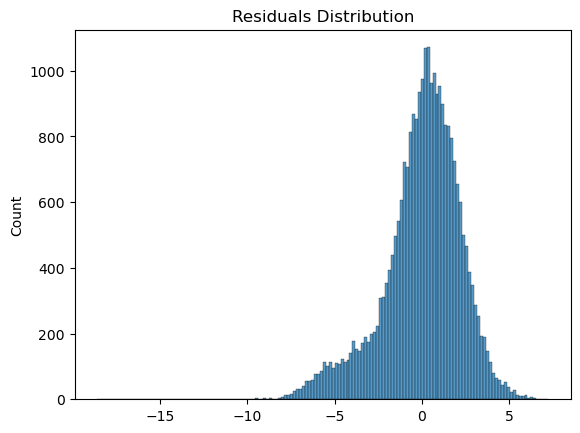

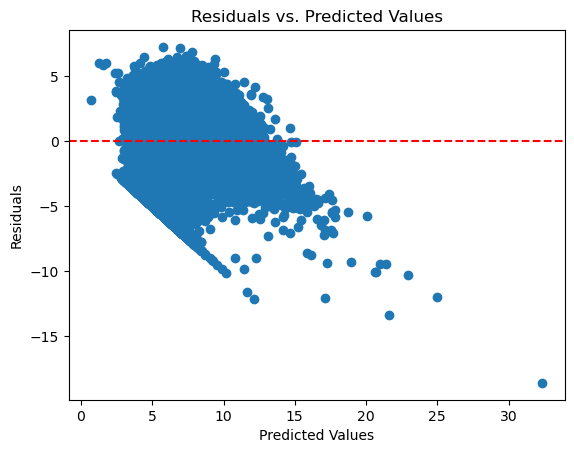

                                    Features         VIF
0                                      const  109.375030
1     Difference in average topic prevalence    1.016965
2   Difference in average topic prevalence^2    1.012541
3                              Loved Project    1.066852
4                                      Video    1.149879
5                           Funding Duration    1.091922
6                       Log(Number of Words)    1.240509
7                          Log(Funding Goal)    1.228358
8                                    Updates    1.218586
9                                    Rewards    1.213773
10                        Number of projects    1.054531


In [306]:
# Assuming 'model_squared_time' is your fitted model

# 1. Linearity
# Visualize scatter plots of predictors vs. response

# 2. Normality of Residuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(model_design.resid)
plt.title('Residuals Distribution')
plt.show()

# 3. Homoscedasticity
plt.scatter(model_design.predict(), model_design.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

# 4. Independence of Residuals
# Use Durbin-Watson test or plot ACF of residuals

# 5. No Endogeneity
# Theoretical validation based on domain knowledge

# 6. Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["Features"] = X_design_with_intercept.columns
vif["VIF"] = [variance_inflation_factor(X_design_with_intercept.values, i) for i in range(X_design_with_intercept.shape[1])]
print(vif)

# 7. No Perfect Multicollinearity
# Manual inspection of relationships between predictors

# Additional notes:

# Latex table Regression

In [336]:
from statsmodels.iolib.summary2 import summary_col

# Assuming reg0, reg1, reg2 are your regression models

# Extract information for each model
info_dict = {
    'AIC': lambda x: f"{x.aic:.0f}",
    'BIC': lambda x: f"{x.bic:.0f}",
    'N':lambda x: "{0:d}".format(int(x.nobs))
    #'Cond. No.': lambda x: f"{x.condition_number:.2f}"
}

# Select the variables you want to include in the summary (excluding dummy variables)
included_variables = ['Difference in average topic prevalence', 'Difference in average topic prevalence^2',
                      'Loved Project', 'Video', 'Funding Duration', 'Log(Number of Words)', 'Log(Funding Goal)', 'Updates', 'Rewards', 'Number of projects', 'const']  # Add the variables you want to include

# Create a summary table for the selected variables
summary = summary_col(
    [model_technology1, model_technology2, model_games1, model_games2, model_design1, model_design2],
    model_names=['Technology Category','Technology Category', 'Games Category', 'Games Category','Design Category', 'Design Category'], 
    stars=True, 
    float_format='%0.3f',
    info_dict=info_dict,
    regressor_order=included_variables  # Specify the order of regressors in the table
)

# Print the customized summary table
print(summary)

latex_table = summary.as_latex() 



                                         Technology Category I Technology Category II Games Category I Games Category II Design Category I Design Category II
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Difference in average topic prevalence   -1.092***             -0.909***              1.809***         2.094***          1.270***          1.174***          
                                         (0.098)               (0.100)                (0.088)          (0.112)           (0.146)           (0.149)           
Difference in average topic prevalence^2                       -1.653***                               0.765***                            -3.437***         
                                                               (0.217)                                 (0.210)                             (0.619)           
Loved Project                            1.894***  

In [337]:
print(latex_table)

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllllll}
\hline
                                         & Technology Category I & Technology Category II & Games Category I & Games Category II & Design Category I & Design Category II  \\
\hline
Difference in average topic prevalence   & -1.092***             & -0.909***              & 1.809***         & 2.094***          & 1.270***          & 1.174***            \\
                                         & (0.098)               & (0.100)                & (0.088)          & (0.112)           & (0.146)           & (0.149)             \\
Difference in average topic prevalence^2 &                       & -1.653***              &                  & 0.765***          &                   & -3.437***           \\
                                         &                       & (0.217)                &                  & (0.210)           &                   & (0.619)             \\
Loved Project                            &

# Latex table Topic Representations

In [343]:
lda_model_technology.print_topics(100)

[(0,
  '0.100*"business" + 0.047*"customer" + 0.032*"item" + 0.031*"company" + 0.024*"money" + 0.022*"price" + 0.021*"market" + 0.021*"fee" + 0.018*"sale" + 0.018*"cost"'),
 (1,
  '0.071*"beta" + 0.065*"relationship" + 0.044*"mail" + 0.036*"tester" + 0.032*"theory" + 0.029*"target" + 0.029*"battle" + 0.024*"stick" + 0.024*"god" + 0.022*"nature"'),
 (2,
  '0.102*"motor" + 0.078*"speed" + 0.071*"flight" + 0.024*"plane" + 0.022*"aircraft" + 0.022*"pod" + 0.022*"pilot" + 0.021*"control" + 0.021*"helicopter" + 0.017*"rotation"'),
 (3,
  '0.290*"home" + 0.050*"door" + 0.050*"house" + 0.028*"office" + 0.026*"family" + 0.018*"garage" + 0.016*"mother" + 0.014*"bathroom" + 0.014*"night" + 0.014*"bed"'),
 (4,
  '0.319*"data" + 0.060*"information" + 0.033*"analysis" + 0.027*"algorithm" + 0.026*"database" + 0.020*"log" + 0.020*"analytics" + 0.016*"anxiety" + 0.015*"chart" + 0.012*"insight"'),
 (5,
  '0.098*"extension" + 0.081*"password" + 0.047*"reference" + 0.043*"phrase" + 0.033*"chore" + 0.031*"

In [344]:
lda_model_games.print_topics(100)

[(0,
  '0.219*"module" + 0.179*"wood" + 0.054*"case" + 0.053*"crawl" + 0.048*"curse" + 0.044*"classic" + 0.034*"candy" + 0.031*"dcc" + 0.030*"dungeon_crawl" + 0.027*"chronicle"'),
 (1,
  '0.036*"kingdom" + 0.020*"soul" + 0.019*"knight" + 0.018*"demon" + 0.017*"shadow" + 0.017*"lord" + 0.016*"dark" + 0.014*"realm" + 0.014*"castle" + 0.014*"king"'),
 (2,
  '0.090*"animal" + 0.053*"fulfillment" + 0.052*"oracle" + 0.032*"duty" + 0.032*"canada" + 0.027*"bird" + 0.024*"flower" + 0.022*"china" + 0.021*"shark" + 0.021*"australia"'),
 (3,
  '0.057*"app" + 0.043*"user" + 0.031*"software" + 0.031*"code" + 0.030*"computer" + 0.028*"server" + 0.025*"device" + 0.019*"phone" + 0.015*"store" + 0.015*"platform"'),
 (4,
  '0.209*"tile" + 0.123*"wall" + 0.046*"mountain" + 0.037*"clan" + 0.021*"corner" + 0.019*"door" + 0.018*"zodiac" + 0.017*"hall" + 0.017*"mirror" + 0.016*"plate"'),
 (5,
  '0.226*"rule" + 0.082*"sheet" + 0.066*"scenario" + 0.023*"character_sheet" + 0.022*"counter" + 0.018*"vote" + 0.017*

In [345]:
lda_model_design.print_topics(100)

[(0,
  '0.265*"wallet" + 0.210*"pocket" + 0.192*"leather" + 0.054*"cash" + 0.031*"slot" + 0.023*"access" + 0.015*"band" + 0.015*"slim" + 0.010*"thread" + 0.010*"card_cash"'),
 (1,
  '0.152*"adventure" + 0.115*"tent" + 0.084*"gear" + 0.068*"season" + 0.059*"mountain" + 0.040*"rope" + 0.038*"trail" + 0.027*"ground" + 0.021*"trip" + 0.017*"builder"'),
 (2,
  '0.028*"market" + 0.024*"company" + 0.022*"problem" + 0.020*"solution" + 0.018*"need" + 0.017*"patent" + 0.014*"development" + 0.013*"customer" + 0.012*"medium" + 0.011*"issue"'),
 (3,
  '0.128*"city" + 0.061*"park" + 0.054*"pop" + 0.038*"york" + 0.029*"land" + 0.027*"disc" + 0.024*"culture" + 0.023*"wing" + 0.023*"state" + 0.022*"neighborhood"'),
 (4,
  '0.067*"app" + 0.064*"device" + 0.050*"data" + 0.045*"wireless" + 0.041*"technology" + 0.034*"control" + 0.031*"software" + 0.029*"user" + 0.021*"voice" + 0.018*"connection"'),
 (5,
  '0.122*"tea" + 0.102*"carrier" + 0.037*"clasp" + 0.034*"creature" + 0.030*"circulation" + 0.022*"sche